In [ ]:
!pip install karateclub networkx numpy matplotlib

In [ ]:
!pip install torch-geometric

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

In [5]:
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk

In [7]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Processing...
Done!


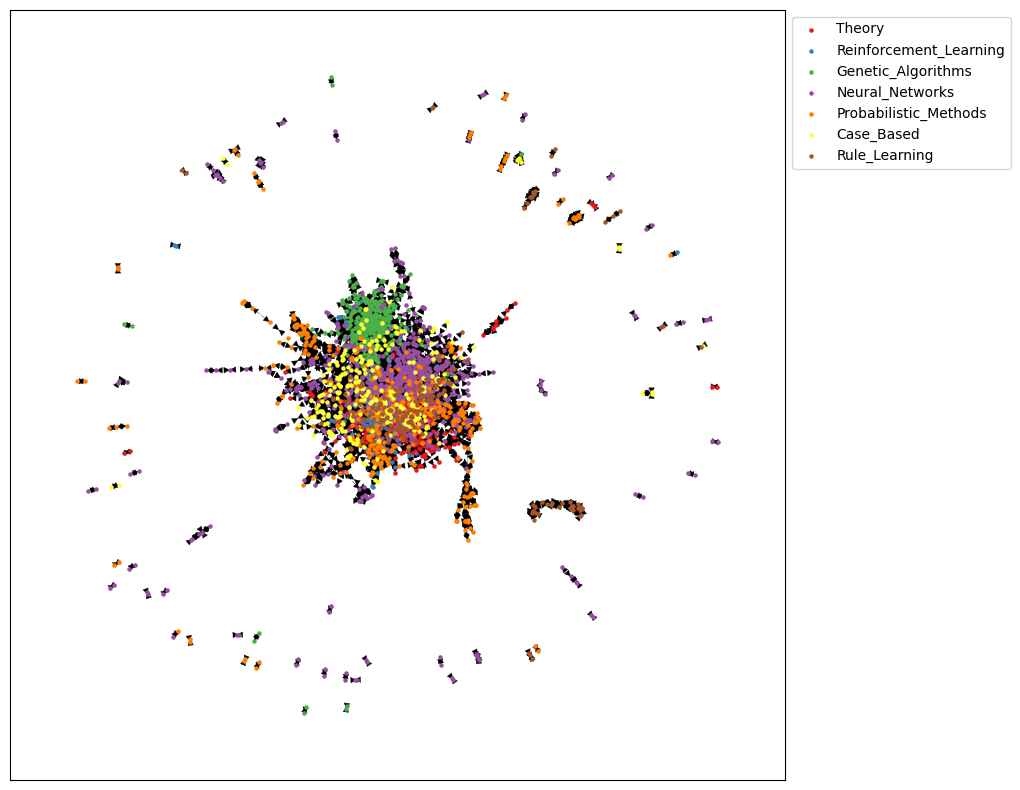

In [12]:
import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from sklearn.linear_model import LogisticRegression
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import time

# Load the Cora dataset
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]


G = to_networkx(data)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [13]:
# Split the data into training and testing sets
num_nodes = data.num_nodes
indices = np.arange(num_nodes)
random_state = 42  # Set your desired random state value
np.random.seed(random_state)
np.random.shuffle(indices)
# print(indices)
split_idx = int(0.8 * num_nodes)  # 80-20 split
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

# DeepWalk to get node embeddings
networkx_graph = to_networkx(data)

# Measure training time
start_time = time.time()
deepwalk = DeepWalk()
deepwalk.fit(networkx_graph)
training_time = time.time() - start_time
print(f"Training Time: {training_time:.4f} seconds")

# Measure inference time
start_time = time.time()
all_embeddings = deepwalk.get_embedding()
inference_time = time.time() - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

# Split embeddings into train and test
train_embeddings = all_embeddings[train_idx]
test_embeddings = all_embeddings[test_idx]

# Prepare labels for training and testing
train_labels = data.y[train_idx]
test_labels = data.y[test_idx]

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42, class_weight= 'balanced')

# Measure training time for the logistic regression classifier
start_time = time.time()
classifier.fit(train_embeddings, train_labels)
training_time_classifier = time.time() - start_time
print(f"Classifier Training Time: {training_time_classifier:.4f} seconds")

# Evaluate the classifier
start_time = time.time()
y_pred = classifier.predict(test_embeddings)
inference_time_classifier = time.time() - start_time
print(f"Classifier Inference Time: {inference_time_classifier:.4f} seconds")

accuracy = accuracy_score(test_labels, y_pred)
print(classification_report(test_labels, y_pred))
print(f"Accuracy: {accuracy}")


Training Time: 21.5932 seconds
Inference Time: 0.0036 seconds
Classifier Training Time: 0.3867 seconds
Classifier Inference Time: 0.0012 seconds
              precision    recall  f1-score   support

           0       0.70      0.61      0.65        71
           1       0.58      0.75      0.65        44
           2       0.81      0.88      0.84        81
           3       0.76      0.64      0.70       150
           4       0.59      0.58      0.59        91
           5       0.67      0.78      0.72        67
           6       0.67      0.74      0.70        38

    accuracy                           0.69       542
   macro avg       0.68      0.71      0.69       542
weighted avg       0.70      0.69      0.69       542

Accuracy: 0.6937269372693727


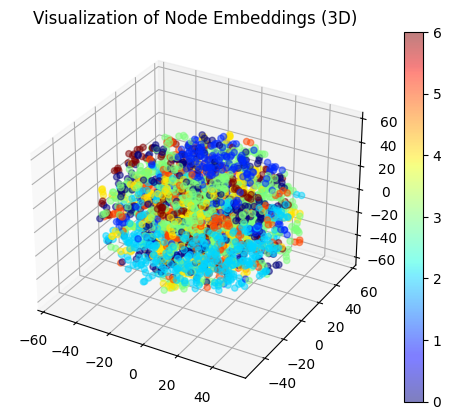

In [ ]:
# Visualize embeddings using t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(all_embeddings)

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=data.y.numpy(), cmap="jet", alpha=0.5)
ax.set_title('Visualization of Node Embeddings (3D)')
fig.colorbar(scatter)
plt.show()